# Symbolic Regression in High Energy Physics: Building an Interpretable Foundational Model

## Create normalized dataset script - CVS - train, val, test

In [ ]:
# Dataset processing code

import os
import random
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tokenizer import Tokenizer # Assuming this is a custom local module

@dataclass
class Config:
    """Holds all script configuration."""
    data_dir: str = '/content/drive/My Drive/Data Files No Momentum Permutation May 2025-selected'
    source_filename: str = 'processed_expressions_output_final13.txt'
    output_prefix: str = 'normalized_expressions_output'

    # Augmentation & Normalization settings
    apply_normalization: bool = True
    samples_per_expression: int = 1
    index_token_pool: int = 500
    momentum_token_pool: int = 500

    # Splitting & Reproducibility
    test_split_size: float = 0.01
    validation_split_size: float = 0.5 # 0.5 of the test_split_size
    seed: int = 42

def _normalize_token_type(tokens, mapping, prefix, pool_size):
    """
    Generic helper to map specific token types (e.g., 'INDEX_') to a
    normalized, recycled set of new tokens.
    """
    new_token_generator = (f"{prefix}_{i}" for i in range(pool_size))
    normalized_tokens = []

    for token in tokens:
        if token.startswith(prefix):
            if token not in mapping:
                try:
                    mapping[token] = next(new_token_generator)
                except StopIteration:
                    raise ValueError(f"Ran out of tokens for {prefix}. Increase pool size.")
            normalized_tokens.append(mapping[token])
        else:
            normalized_tokens.append(token)

    return normalized_tokens, mapping

def normalize_expressions(tokenizer, expressions, config):
    """
    Normalizes index and momentum tokens within a list of expressions to a
    consistent, smaller vocabulary.
    """
    normalized_exprs = []
    index_map, momentum_map = {}, {}

    for expr in tqdm(expressions, desc="Normalizing expressions"):
        tokens = tokenizer.src_tokenize(expr, config.seed)

        # Normalize indices
        tokens, index_map = _normalize_token_type(
            tokens, index_map, "INDEX_", config.index_token_pool
        )
        # Normalize momenta
        tokens, momentum_map = _normalize_token_type(
            tokens, momentum_map, "MOMENTUM_", config.momentum_token_pool
        )

        normalized_exprs.append("".join(tokens))

    return normalized_exprs

def process_source_file(lines, tokenizer, config):
    """
    Applies augmentation and normalization to raw text lines from the source file.
    """
    # Filter for valid lines containing the separator " : "
    expressions = [line.strip() for line in lines if " : " in line]

    augmented_expressions = []
    for expr in tqdm(expressions, desc='Augmenting expressions'):
        # Generate N random variations for each expression
        seeds = [random.randint(1, 1000) for _ in range(config.samples_per_expression)]
        for seed in seeds:
            augmented_expressions.append(tokenizer.src_replace(expr, seed))

    if config.apply_normalization:
        processed_expressions = normalize_expressions(tokenizer, augmented_expressions, config)
    else:
        processed_expressions = augmented_expressions

    df = pd.DataFrame({"amp": processed_expressions})
    df.drop_duplicates(inplace=True)
    return df

def main():
    """Main script execution."""
    config = Config()

    # Set random seeds for reproducibility
    random.seed(config.seed)
    np.random.seed(config.seed)

    base_path = Path(config.data_dir)
    source_file = base_path / config.source_filename

    try:
        print(f"Reading from: {source_file}")
        with open(source_file, 'r', encoding='utf-8', errors='ignore') as f:
            lines = f.readlines()

    except FileNotFoundError:
        print(f"ERROR: Source file not found at {source_file}")
        return
    except Exception as e:
        print(f"An unexpected error occurred while reading the file: {e}")
        return

    # Assume tokenizer is available
    tokenizer = Tokenizer()

    # Process data and create a DataFrame
    df = process_source_file(lines, tokenizer, config)

    # Split the data into train, validation, and test sets
    df_train, df_temp = train_test_split(
        df, test_size=config.test_split_size, random_state=config.seed
    )
    df_valid, df_test = train_test_split(
        df_temp, test_size=config.validation_split_size, random_state=config.seed
    )

    datasets = {
        'train': df_train,
        'valid': df_valid,
        'test': df_test
    }

    # Save the split datasets to CSV files
    for split_name, dataset_df in datasets.items():
        dataset_df = dataset_df.reset_index(drop=True)
        output_file = base_path / f"{config.output_prefix}_{split_name}.csv"
        dataset_df.to_csv(output_file, index=False)
        print(f"Successfully saved {split_name} data to {output_file} ({len(dataset_df)} rows)")

if __name__ == "__main__":
    main()

## Data analysis

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📈 Analyzing file: normalized_expressions_output_train.csv

📊 Statistical Summary of Sequence Lengths:
count     83037.000000
mean       8379.812325
std       11923.763375
min         181.000000
50%        4380.000000
75%        8800.000000
90%       19945.600000
95%       31539.400000
98%       48697.240000
99%       55160.520000
max      175071.000000


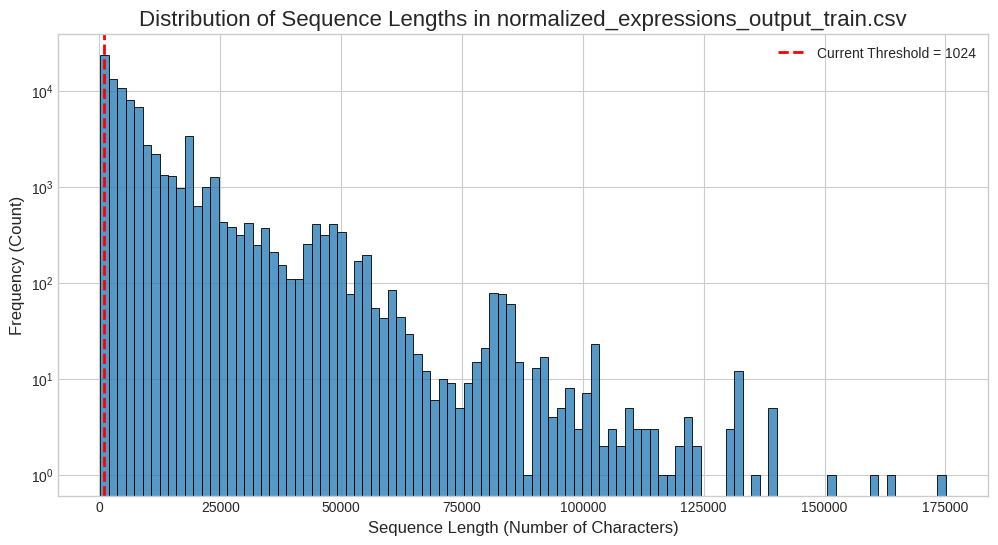


--------------------------------------------------------------------------------

📈 Analyzing file: normalized_expressions_output_valid.csv

📊 Statistical Summary of Sequence Lengths:
count      729.000000
mean      7984.249657
std      10558.538814
min        391.000000
50%       4698.000000
75%       8527.000000
90%      19039.800000
95%      27695.200000
98%      47685.520000
99%      54787.800000
max      84137.000000


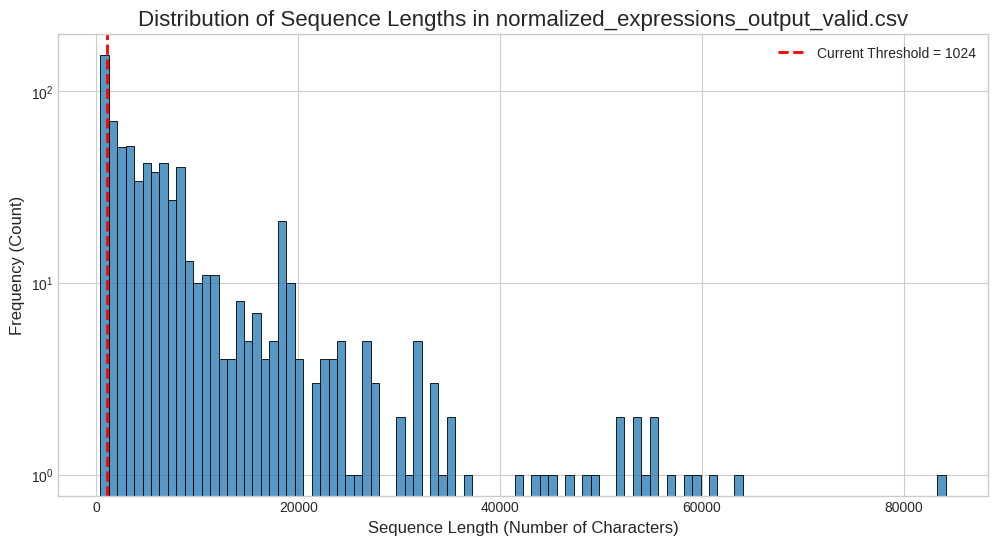


--------------------------------------------------------------------------------



In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# --- Script Settings ---
DATA_DIR = '/content/drive/My Drive/Data Files No Momentum Permutation May 2025-selected'
TRAIN_FILE = 'normalized_expressions_output_train.csv'
VALID_FILE = 'normalized_expressions_output_valid.csv'
TARGET_COLUMN = 'amp'  # Column containing the text sequences
MAX_LENGTH_VIS = 1024  # A vertical line to draw on the plot for reference

def analyze_and_plot_lengths(filepath, column):
    """
    Loads a CSV, analyzes sequence lengths for a specific column,
    and visualizes the distribution.
    """
    filename = os.path.basename(filepath)
    print(f"Analyzing: {filename}")

    if not os.path.exists(filepath):
        print(f"  -> File not found. Skipping.\n")
        return

    # Load data and calculate the length of each sequence
    data = pd.read_csv(filepath)
    data.dropna(subset=[column], inplace=True)
    lengths = data[column].str.len()

    if lengths.empty:
        print(f"  -> No data found in column '{column}'. Skipping.\n")
        return

    # Show key statistics about the sequence lengths
    print("\nLength Statistics:")
    print(lengths.describe(percentiles=[.5, .75, .90, .95, .99]))

    # Plot the histogram
    plt.figure(figsize=(12, 6))
    sns.histplot(lengths, bins=100, color='skyblue')

    plt.axvline(
        x=MAX_LENGTH_VIS,
        color='r',
        linestyle='--',
        label=f'Reference Length = {MAX_LENGTH_VIS}'
    )

    plt.title(f'Distribution of Sequence Lengths in {filename}')
    plt.xlabel('Sequence Length (Characters)')
    plt.ylabel('Frequency (Log Scale)')
    plt.yscale('log')  # Log scale is useful for seeing tails clearly
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    print("-" * 70 + "\n")

def main():
    """
    Main function to run the analysis script.
    """
    # Mount Google Drive to access the dataset
    try:
        drive.mount('/content/drive', force_remount=True)
    except Exception as e:
        print(f"Error mounting Google Drive: {e}")
        return # Stop if we can't access files

    # Construct the full paths to the data files
    train_data_path = os.path.join(DATA_DIR, TRAIN_FILE)
    valid_data_path = os.path.join(DATA_DIR, VALID_FILE)

    # Run the analysis on both files
    analyze_and_plot_lengths(train_data_path, TARGET_COLUMN)
    analyze_and_plot_lengths(valid_data_path, TARGET_COLUMN)

if __name__ == '__main__':
    main()

## Mamba

In [ ]:
import os
import sys
import json
import pandas as pd
from typing import List

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from tqdm.auto import tqdm

# Attempt to import mamba, which is a required dependency.
try:
    from mamba_ssm import Mamba
except ImportError:
    print("Mamba-ssm not found. Please install it with 'pip install mamba-ssm'.")
    sys.exit(1)

# Attempt to mount Google Drive, gracefully handling non-Colab environments.
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except (ImportError, ModuleNotFoundError):
    IN_COLAB = False
    print("Not running in Google Colab. Assuming local file paths.")


# --- Configuration ---
# All user-configurable settings are grouped here for easy access.
class Config:
    # Paths and Files
    # If in Colab, use the Google Drive path. Otherwise, assume a local 'data' folder.
    DATA_DIR = '/content/drive/My Drive/Data Files No Momentum Permutation May 2025-selected' if IN_COLAB else 'data'
    TRAIN_FILE = 'normalized_expressions_output_train.csv'
    VALID_FILE = 'normalized_expressions_output_valid.csv'
    VOCAB_VERSION = 1

    # Model Hyperparameters
    D_MODEL = 64
    NUM_LAYERS = 2
    NUM_MEMORY_BLOCKS = 1

    # Training Hyperparameters
    BATCH_SIZE = 8
    LEARNING_RATE = 5e-5
    NUM_EPOCHS = 2
    CLIP_GRAD_NORM = 1.0
    MAX_SEQ_LEN = 16384 # Max sequence length for filtering data

# --- Data Handling ---

def build_or_load_vocab(data_path: str, vocab_path: str) -> dict:
    """Creates a character vocabulary from the training data or loads an existing one."""
    if os.path.exists(vocab_path):
        print(f"Found existing vocabulary at {vocab_path}. Loading...")
        with open(vocab_path, 'r') as f:
            return json.load(f)

    print("Building new character vocabulary...")
    try:
        df = pd.read_csv(data_path).dropna(subset=['amp'])
        full_text = "".join(df['amp'])
        unique_chars = sorted(list(set(full_text)))

        # Reserve index 0 for the padding token.
        char_to_int = {'<PAD>': 0}
        char_to_int.update({char: i + 1 for i, char in enumerate(unique_chars)})

        with open(vocab_path, 'w') as f:
            json.dump(char_to_int, f)
        print(f"Vocabulary saved to {vocab_path}")
        return char_to_int
    except FileNotFoundError:
        print(f"FATAL: Training data not found at {data_path}. Cannot build vocabulary.")
        sys.exit(1)

class ExpressionsDataset(Dataset):
    """Custom PyTorch Dataset for loading and filtering expression sequences."""
    def __init__(self, csv_path: str, vocab: dict, max_len: int):
        self.vocab = vocab
        self.max_len = max_len

        if not os.path.exists(csv_path):
            print(f"Warning: File not found at {csv_path}. This dataset will be empty.")
            self.data = []
            return

        df = pd.read_csv(csv_path).dropna(subset=['amp'])
        original_count = len(df)

        # Filter sequences that are too long or too short.
        df = df[df['amp'].str.len().between(2, self.max_len)]

        print(f"Filtered {os.path.basename(csv_path)}: "
              f"kept {len(df)} of {original_count} sequences.")

        self.data = [
            torch.tensor([self.vocab.get(char, 0) for char in expr], dtype=torch.long)
            for expr in df['amp']
        ]

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.data[idx]

def collate_fn(batch: List[torch.Tensor]):
    """Pads sequences in a batch and creates input/target pairs for the language model."""
    # Input is the sequence, target is the sequence shifted by one.
    inputs = [item[:-1] for item in batch]
    targets = [item[1:] for item in batch]

    # Pad with 0, which corresponds to the '<PAD>' token.
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    padded_targets = pad_sequence(targets, batch_first=True, padding_value=0)

    return padded_inputs, padded_targets

# --- Model Architecture ---

class MambaBlock(nn.Module):
    """A residual block wrapping the Mamba layer with LayerNorm."""
    def __init__(self, d_model: int, **kwargs):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.mamba = Mamba(d_model=d_model, **kwargs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mamba(self.norm(x)) + x

class MambaEncoder(nn.Module):
    """Encodes input tokens into a sequence of hidden states."""
    def __init__(self, vocab_size: int, d_model: int, num_layers: int, **kwargs):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([MambaBlock(d_model, **kwargs) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        x = self.embedding(tokens)
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

class NeuralMemoryModule(nn.Module):
    """A simplified memory module using learned parameter-based memory."""
    def __init__(self, d_model: int, num_memory_blocks: int):
        super().__init__()
        self.memory_blocks = nn.Parameter(torch.randn(num_memory_blocks, d_model))
        self.d_model = d_model

    def retrieve(self, query: torch.Tensor) -> torch.Tensor:
        """Retrieves a global memory context and expands it to the input shape."""
        # Simple retrieval: use the mean of all memory blocks as a global context vector.
        global_context = self.memory_blocks.mean(dim=0, keepdim=True)
        batch_size, seq_len, _ = query.size()
        return global_context.unsqueeze(0).expand(batch_size, seq_len, self.d_model)

class MambaDecoder(nn.Module):
    """Decodes hidden states into output logits for token prediction."""
    def __init__(self, vocab_size: int, d_model: int, num_layers: int, **kwargs):
        super().__init__()
        self.layers = nn.ModuleList([MambaBlock(d_model, **kwargs) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.output_head = nn.Linear(d_model, vocab_size)

    def forward(self, encoded_input: torch.Tensor, memory: torch.Tensor) -> torch.Tensor:
        # Fuse the encoded sequence with the global memory context.
        x = encoded_input + memory
        for layer in self.layers:
            x = layer(x)
        return self.output_head(self.norm(x))

# --- Training Utilities ---

def calculate_accuracy(logits: torch.Tensor, targets: torch.Tensor):
    """Calculates token and sequence level accuracy, ignoring padding."""
    predictions = torch.argmax(logits, dim=-1)
    mask = (targets != 0)

    # Token-level accuracy
    correct_tokens = ((predictions == targets) & mask).sum().item()
    total_tokens = mask.sum().item()

    # Sequence-level accuracy (exact match)
    valid_tokens_per_seq = mask.sum(dim=1)
    correct_tokens_per_seq = ((predictions == targets) & mask).sum(dim=1)
    correct_sequences = (correct_tokens_per_seq == valid_tokens_per_seq).sum().item()
    total_sequences = targets.size(0)

    return correct_tokens, total_tokens, correct_sequences, total_sequences

# --- Main Execution Block ---

def main():
    config = Config()

    # Setup paths
    os.makedirs(config.DATA_DIR, exist_ok=True)
    train_path = os.path.join(config.DATA_DIR, config.TRAIN_FILE)
    valid_path = os.path.join(config.DATA_DIR, config.VALID_FILE)
    vocab_path = os.path.join(config.DATA_DIR, f'char_vocab_v{config.VOCAB_VERSION}.json')
    checkpoint_path = os.path.join(config.DATA_DIR, 'model_checkpoint.pt')

    # Build or load vocabulary
    vocab = build_or_load_vocab(train_path, vocab_path)
    vocab_size = len(vocab)
    print(f"Vocabulary loaded with {vocab_size} tokens.")

    # Create datasets and dataloaders
    train_dataset = ExpressionsDataset(train_path, vocab, config.MAX_SEQ_LEN)
    valid_dataset = ExpressionsDataset(valid_path, vocab, config.MAX_SEQ_LEN)

    if len(train_dataset) == 0:
        print("Training dataset is empty. Halting.")
        return

    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    # Setup model, optimizer, and loss function
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    encoder = MambaEncoder(vocab_size, config.D_MODEL, config.NUM_LAYERS).to(device)
    nmm = NeuralMemoryModule(config.D_MODEL, config.NUM_MEMORY_BLOCKS).to(device)
    decoder = MambaDecoder(vocab_size, config.D_MODEL, config.NUM_LAYERS).to(device)

    all_params = list(encoder.parameters()) + list(nmm.parameters()) + list(decoder.parameters())
    optimizer = torch.optim.Adam(all_params, lr=config.LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=0) # Ignore padding

    best_valid_loss = float('inf')

    print("\nStarting training...")
    for epoch in range(config.NUM_EPOCHS):
        # --- Training Phase ---
        encoder.train()
        nmm.train()
        decoder.train()
        total_train_loss = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.NUM_EPOCHS} [Train]")
        for inputs, targets in train_bar:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            encoded = encoder(inputs)
            memory = nmm.retrieve(encoded)
            logits = decoder(encoded, memory)

            loss = criterion(logits.view(-1, vocab_size), targets.view(-1))
            loss.backward()

            torch.nn.utils.clip_grad_norm_(all_params, config.CLIP_GRAD_NORM)
            optimizer.step()

            total_train_loss += loss.item()
            train_bar.set_postfix({'loss': f'{total_train_loss / (train_bar.n + 1):.4f}'})

        avg_train_loss = total_train_loss / len(train_loader)

        # --- Validation Phase ---
        encoder.eval()
        nmm.eval()
        decoder.eval()
        total_valid_loss = 0
        total_c_tokens, total_v_tokens, total_c_seqs, total_v_seqs = 0, 0, 0, 0

        if len(valid_loader) > 0:
            valid_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{config.NUM_EPOCHS} [Validate]")
            with torch.no_grad():
                for inputs, targets in valid_bar:
                    inputs, targets = inputs.to(device), targets.to(device)

                    encoded = encoder(inputs)
                    memory = nmm.retrieve(encoded)
                    logits = decoder(encoded, memory)

                    loss = criterion(logits.view(-1, vocab_size), targets.view(-1))
                    total_valid_loss += loss.item()

                    c_tok, v_tok, c_seq, v_seq = calculate_accuracy(logits, targets)
                    total_c_tokens += c_tok
                    total_v_tokens += v_tok
                    total_c_seqs += c_seq
                    total_v_seqs += v_seq

                    valid_bar.set_postfix({'v_loss': f'{total_valid_loss / (valid_bar.n + 1):.4f}'})

            avg_valid_loss = total_valid_loss / len(valid_loader)
            token_acc = total_c_tokens / total_v_tokens if total_v_tokens > 0 else 0
            seq_acc = total_c_seqs / total_v_seqs if total_v_seqs > 0 else 0

            print(f"Epoch {epoch+1} Summary: "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Valid Loss: {avg_valid_loss:.4f} | "
                  f"Token Acc: {token_acc:.4f} | "
                  f"Seq Acc: {seq_acc:.4f}")

            # Save the best model
            if avg_valid_loss < best_valid_loss:
                best_valid_loss = avg_valid_loss
                torch.save({
                    'epoch': epoch + 1,
                    'encoder_state_dict': encoder.state_dict(),
                    'decoder_state_dict': decoder.state_dict(),
                    'nmm_state_dict': nmm.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': best_valid_loss,
                }, checkpoint_path)
                print(f"-> New best model saved to {checkpoint_path}")
        else:
            print(f"Epoch {epoch+1} Summary: Train Loss: {avg_train_loss:.4f} | Validation skipped.")

    print("\nTraining complete.")

if __name__ == "__main__":
    main()

## Transformer Model

In [ ]:
# A PyTorch implementation of a Transformer for character-level language modeling.
# This script handles data loading, vocabulary creation, training, and validation.

import os
import json
import math
import pandas as pd
from typing import List

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm

# --- Google Colab Specific ---
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_MOUNTED = True
    print("Google Drive mounted successfully.")
except (ImportError, Exception):
    print("Could not mount Google Drive. Assuming local execution.")
    DRIVE_MOUNTED = False

# ==============================================================================
#                                 CONFIGURATION
# ==============================================================================

# -- File Paths --
# If not on Colab, this will default to the current directory.
BASE_DIR = '/content/drive/My Drive/Data Files No Momentum Permutation May 2025-selected' if DRIVE_MOUNTED else '.'
TRAIN_FILE = os.path.join(BASE_DIR, 'normalized_expressions_output_train.csv')
VALID_FILE = os.path.join(BASE_DIR, 'normalized_expressions_output_valid.csv')
VOCAB_VERSION = 1
VOCAB_FILE = os.path.join(BASE_DIR, f'char_vocab_v{VOCAB_VERSION}.json')
CHECKPOINT_FILE = os.path.join(BASE_DIR, 'transformer_checkpoint.pt')

# -- Model Hyperparameters --
D_MODEL = 256            # Embedding dimension
NUM_LAYERS = 4           # Number of Transformer encoder/decoder layers
NHEAD = 4                # Number of attention heads
DIM_FEEDFORWARD = 1024   # Hidden dimension in the feedforward networks
DROPOUT = 0.1
MAX_SEQ_LEN = 4096       # Max sequence length to process from the dataset

# -- Training Hyperparameters --
BATCH_SIZE = 4
LEARNING_RATE = 5e-4
NUM_EPOCHS = 15
CLIP_GRAD_NORM = 1.0
ACCUMULATION_STEPS = 2   # Simulates a larger batch size (BATCH_SIZE * ACCUMULATION_STEPS)

# ==============================================================================
#                                 DATA SETUP
# ==============================================================================

def build_or_load_vocab(vocab_path: str, train_csv_path: str) -> dict:
    """Loads a vocabulary file or builds it from the training data."""
    if os.path.exists(vocab_path):
        print(f"Loading existing vocabulary from {vocab_path}")
        with open(vocab_path, 'r') as f:
            return json.load(f)

    print(f"Vocabulary not found. Building from {train_csv_path}...")
    if not os.path.exists(train_csv_path):
        raise FileNotFoundError(f"Training data not found at {train_csv_path}. Cannot build vocabulary.")

    df = pd.read_csv(train_csv_path).dropna(subset=['amp'])
    full_text = "".join(df['amp'])
    unique_chars = sorted(list(set(full_text)))

    # Create mapping, reserving 0 for padding
    char_to_int = {char: i + 1 for i, char in enumerate(unique_chars)}
    char_to_int['<PAD>'] = 0

    with open(vocab_path, 'w') as f:
        json.dump(char_to_int, f, indent=4)

    print(f"Vocabulary saved to {vocab_path} with {len(char_to_int)} tokens.")
    return char_to_int

class ExpressionDataset(Dataset):
    """Reads expression data from a CSV and converts it to integer tensors."""
    def __init__(self, filepath: str, vocab_map: dict, max_len: int = 1024):
        if not os.path.exists(filepath):
            print(f"Warning: Data file not found at {filepath}. Dataset will be empty.")
            self.data = []
            return

        df = pd.read_csv(filepath).dropna(subset=['amp'])

        # Filter sequences that are too long or too short (empty sequences break the model)
        original_count = len(df)
        df = df[df['amp'].str.len().between(2, max_len)]
        new_count = len(df)

        if original_count > 0:
            print(f"Filtered {os.path.basename(filepath)}: {new_count}/{original_count} samples remain (2 <= length <= {max_len}).")

        # Tokenize expressions using the provided vocabulary map
        self.data = [
            torch.tensor([vocab_map.get(char, 0) for char in expr], dtype=torch.long)
            for expr in df['amp']
        ]

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.data[idx]

def collate_fn(batch: List[torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor]:
    """Pads sequences and creates input/target pairs for language modeling."""
    # For language modeling, input is the sequence and the target is the sequence shifted by one
    inputs = [item[:-1] for item in batch]
    targets = [item[1:] for item in batch]

    # Pad to the length of the longest sequence in the batch using the <PAD> token (value 0)
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    padded_targets = pad_sequence(targets, batch_first=True, padding_value=0)

    return padded_inputs, padded_targets

# ==============================================================================
#                               MODEL ARCHITECTURE
# ==============================================================================

class PositionalEncoding(nn.Module):
    """Injects sinusoidal position information into the embeddings."""
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class LanguageTransformer(nn.Module):
    """A standard Transformer model for sequence-to-sequence language modeling."""
    def __init__(self, vocab_size: int, d_model: int, nhead: int, num_encoder_layers: int,
                 num_decoder_layers: int, dim_feedforward: int, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.output_layer = nn.Linear(d_model, vocab_size)
        self._init_weights()

    def _init_weights(self):
        """Initializes weights using Xavier uniform for better stability."""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def _generate_masks(self, src: torch.Tensor, tgt: torch.Tensor) -> tuple:
        """Creates the necessary masks for training."""
        device = src.device
        # Causal mask prevents the decoder from "cheating" by seeing future tokens
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(1), device=device)

        # Padding masks tell the model to ignore <PAD> tokens in the sequences
        src_padding_mask = (src == 0)
        tgt_padding_mask = (tgt == 0)

        return tgt_mask, src_padding_mask, tgt_padding_mask

    def forward(self, src: torch.Tensor, tgt: torch.Tensor) -> torch.Tensor:
        """Forward pass for the transformer."""
        tgt_mask, src_pad_mask, tgt_pad_mask = self._generate_masks(src, tgt)

        # Embed tokens and add positional information
        src_embed = self.pos_encoder(self.embedding(src) * math.sqrt(self.d_model))
        tgt_embed = self.pos_encoder(self.embedding(tgt) * math.sqrt(self.d_model))

        output = self.transformer(
            src_embed,
            tgt_embed,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_pad_mask,
            tgt_key_padding_mask=tgt_pad_mask,
            memory_key_padding_mask=src_pad_mask
        )

        return self.output_layer(output)

# ==============================================================================
#                               TRAINING SCRIPT
# ==============================================================================

def calculate_accuracy(logits: torch.Tensor, targets: torch.Tensor) -> tuple:
    """Calculates token and sequence level accuracy, ignoring padding."""
    preds = logits.argmax(dim=-1)
    non_pad_mask = (targets != 0)

    # Token-level accuracy
    correct_tokens = ((preds == targets) & non_pad_mask).sum().item()
    total_tokens = non_pad_mask.sum().item()

    # Sequence-level accuracy (all tokens in a sequence must be correct)
    correct_in_seq = ((preds == targets) & non_pad_mask).sum(dim=1)
    tokens_in_seq = non_pad_mask.sum(dim=1)
    correct_seqs = (correct_in_seq == tokens_in_seq).sum().item()
    total_seqs = targets.size(0)

    return correct_tokens, total_tokens, correct_seqs, total_seqs

# -- 1. Setup Environment --
print("## -- Setting up for training -- ##")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -- 2. Load Vocabulary and Data --
char_to_int = build_or_load_vocab(VOCAB_FILE, TRAIN_FILE)
VOCAB_SIZE = len(char_to_int)

print("\nLoading datasets...")
train_dataset = ExpressionDataset(TRAIN_FILE, char_to_int, max_len=MAX_SEQ_LEN)
valid_dataset = ExpressionDataset(VALID_FILE, char_to_int, max_len=MAX_SEQ_LEN)

if not train_dataset:
    raise ValueError("Training dataset is empty. Check file path and content.")
if not valid_dataset:
    print("Warning: Validation dataset is empty. Validation steps will be skipped.")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
print(f"Data loaded: {len(train_loader)} training batches, {len(valid_loader)} validation batches.")

# -- 3. Initialize Model and Training Components --
print("\nInitializing model...")
model = LanguageTransformer(
    vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    nhead=NHEAD,
    num_encoder_layers=NUM_LAYERS,
    num_decoder_layers=NUM_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT
).to(device)
print(f"Model has {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters.")

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=0) # Ignore the <PAD> token in loss calculation
scaler = GradScaler()
best_valid_loss = float('inf')

# Use OneCycleLR scheduler for better and faster convergence
total_steps = (len(train_loader) // ACCUMULATION_STEPS) * NUM_EPOCHS
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LEARNING_RATE, total_steps=total_steps, pct_start=0.1
)

# -- 4. Start Training --
print(f"\n## -- Starting Training -- ##")
effective_batch_size = BATCH_SIZE * ACCUMULATION_STEPS
print(f"Epochs: {NUM_EPOCHS}, Batch Size: {BATCH_SIZE}, Accumulation: {ACCUMULATION_STEPS} (Effective BS: {effective_batch_size})")

for epoch in range(NUM_EPOCHS):

    # -- Training Phase --
    model.train()
    train_loss = 0
    optimizer.zero_grad()

    train_pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1} Train")
    for i, (inputs, targets) in train_pbar:
        inputs, targets = inputs.to(device), targets.to(device)

        with autocast(): # Enable mixed-precision
            logits = model(src=inputs, tgt=inputs)
            loss = criterion(logits.view(-1, VOCAB_SIZE), targets.view(-1))
            loss = loss / ACCUMULATION_STEPS

        scaler.scale(loss).backward()

        # Update weights after accumulating gradients
        if (i + 1) % ACCUMULATION_STEPS == 0 or (i + 1) == len(train_loader):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD_NORM)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        train_loss += loss.item() * ACCUMULATION_STEPS
        train_pbar.set_postfix({
            'Loss': f'{train_loss / (i + 1):.4f}',
            'LR': f'{scheduler.get_last_lr()[0]:.1e}'
        })

    avg_train_loss = train_loss / len(train_loader)

    # -- Validation Phase --
    if not valid_loader:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {avg_train_loss:.4f}")
        continue

    model.eval()
    valid_loss = 0
    total_c_tokens, total_v_tokens, total_c_seqs, total_v_seqs = 0, 0, 0, 0

    with torch.no_grad():
        for inputs, targets in tqdm(valid_loader, desc=f"Epoch {epoch+1} Valid"):
            inputs, targets = inputs.to(device), targets.to(device)
            with autocast():
                logits = model(src=inputs, tgt=inputs)
                loss = criterion(logits.view(-1, VOCAB_SIZE), targets.view(-1))

            valid_loss += loss.item()

            c_t, v_t, c_s, v_s = calculate_accuracy(logits, targets)
            total_c_tokens += c_t
            total_v_tokens += v_t
            total_c_seqs += c_s
            total_v_seqs += v_s

    avg_valid_loss = valid_loss / len(valid_loader)
    token_acc = total_c_tokens / total_v_tokens if total_v_tokens > 0 else 0
    seq_acc = total_c_seqs / total_v_seqs if total_v_seqs > 0 else 0

    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} -> "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_valid_loss:.4f} | "
        f"Token Acc: {token_acc:.4f} | "
        f"Seq Acc: {seq_acc:.4f}"
    )

    # Save a checkpoint if validation loss improves
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_valid_loss
        }, CHECKPOINT_FILE)
        print(f" ✨ New best validation loss. Checkpoint saved to {CHECKPOINT_FILE}")

    torch.cuda.empty_cache()

print("\n🎉 Training complete!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Building or locating character-level vocabulary...
✅ Character vocabulary loaded with 60 unique tokens.
Filtered normalized_expressions_output_train.csv: Kept 39946 of 83037 sequences (length > 1 and <= 4096).
Filtered normalized_expressions_output_valid.csv: Kept 344 of 729 sequences (length > 1 and <= 4096).

✅ DataLoaders created. Training batches: 9987, Validation batches: 86.
Using device: cuda

🚀 Starting training for 15 epochs with effective batch size of 8...


Epoch 1/15 (Train):   0%|          | 0/9987 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1/15 (Validation):   0%|          | 0/86 [00:00<?, ?it/s]


--- EPOCH 1/15 COMPLETE ---
| Train Loss: 1.1326 | Val Loss: 0.4319 | Val Token Acc: 0.8396 | Val Seq Acc: 0.0000 |
--------------------------------------------------------------------------------------------------------------
✅ New best validation loss! Checkpoint saved to /content/drive/My Drive/Data Files No Momentum Permutation May 2025-selected/transformer_model_checkpoint.pt


Epoch 2/15 (Train):   0%|          | 0/9987 [00:00<?, ?it/s]

Epoch 2/15 (Validation):   0%|          | 0/86 [00:00<?, ?it/s]


--- EPOCH 2/15 COMPLETE ---
| Train Loss: 0.2125 | Val Loss: 0.0001 | Val Token Acc: 1.0000 | Val Seq Acc: 0.9797 |
--------------------------------------------------------------------------------------------------------------
✅ New best validation loss! Checkpoint saved to /content/drive/My Drive/Data Files No Momentum Permutation May 2025-selected/transformer_model_checkpoint.pt


Epoch 3/15 (Train):   0%|          | 0/9987 [00:00<?, ?it/s]

Epoch 3/15 (Validation):   0%|          | 0/86 [00:00<?, ?it/s]


--- EPOCH 3/15 COMPLETE ---
| Train Loss: 0.0031 | Val Loss: 0.0000 | Val Token Acc: 1.0000 | Val Seq Acc: 0.9884 |
--------------------------------------------------------------------------------------------------------------
✅ New best validation loss! Checkpoint saved to /content/drive/My Drive/Data Files No Momentum Permutation May 2025-selected/transformer_model_checkpoint.pt


Epoch 4/15 (Train):   0%|          | 0/9987 [00:00<?, ?it/s]

Epoch 4/15 (Validation):   0%|          | 0/86 [00:00<?, ?it/s]


--- EPOCH 4/15 COMPLETE ---
| Train Loss: 0.0014 | Val Loss: 0.0000 | Val Token Acc: 1.0000 | Val Seq Acc: 0.9884 |
--------------------------------------------------------------------------------------------------------------
✅ New best validation loss! Checkpoint saved to /content/drive/My Drive/Data Files No Momentum Permutation May 2025-selected/transformer_model_checkpoint.pt


Epoch 5/15 (Train):   0%|          | 0/9987 [00:00<?, ?it/s]

Epoch 5/15 (Validation):   0%|          | 0/86 [00:00<?, ?it/s]


--- EPOCH 5/15 COMPLETE ---
| Train Loss: 0.0010 | Val Loss: 0.0000 | Val Token Acc: 1.0000 | Val Seq Acc: 0.9884 |
--------------------------------------------------------------------------------------------------------------
✅ New best validation loss! Checkpoint saved to /content/drive/My Drive/Data Files No Momentum Permutation May 2025-selected/transformer_model_checkpoint.pt


Epoch 6/15 (Train):   0%|          | 0/9987 [00:00<?, ?it/s]

Epoch 6/15 (Validation):   0%|          | 0/86 [00:00<?, ?it/s]


--- EPOCH 6/15 COMPLETE ---
| Train Loss: 0.0008 | Val Loss: 0.0000 | Val Token Acc: 1.0000 | Val Seq Acc: 0.9913 |
--------------------------------------------------------------------------------------------------------------
✅ New best validation loss! Checkpoint saved to /content/drive/My Drive/Data Files No Momentum Permutation May 2025-selected/transformer_model_checkpoint.pt


Epoch 7/15 (Train):   0%|          | 0/9987 [00:00<?, ?it/s]

Epoch 7/15 (Validation):   0%|          | 0/86 [00:00<?, ?it/s]


--- EPOCH 7/15 COMPLETE ---
| Train Loss: 0.0006 | Val Loss: 0.0000 | Val Token Acc: 1.0000 | Val Seq Acc: 0.9971 |
--------------------------------------------------------------------------------------------------------------
✅ New best validation loss! Checkpoint saved to /content/drive/My Drive/Data Files No Momentum Permutation May 2025-selected/transformer_model_checkpoint.pt


Epoch 8/15 (Train):   0%|          | 0/9987 [00:00<?, ?it/s]

Epoch 8/15 (Validation):   0%|          | 0/86 [00:00<?, ?it/s]


--- EPOCH 8/15 COMPLETE ---
| Train Loss: 0.0005 | Val Loss: 0.0000 | Val Token Acc: 1.0000 | Val Seq Acc: 0.9971 |
--------------------------------------------------------------------------------------------------------------


Epoch 9/15 (Train):   0%|          | 0/9987 [00:00<?, ?it/s]

Epoch 9/15 (Validation):   0%|          | 0/86 [00:00<?, ?it/s]


--- EPOCH 9/15 COMPLETE ---
| Train Loss: 0.0004 | Val Loss: 0.0000 | Val Token Acc: 1.0000 | Val Seq Acc: 0.9942 |
--------------------------------------------------------------------------------------------------------------


Epoch 10/15 (Train):   0%|          | 0/9987 [00:00<?, ?it/s]

Epoch 10/15 (Validation):   0%|          | 0/86 [00:00<?, ?it/s]


--- EPOCH 10/15 COMPLETE ---
| Train Loss: 0.0003 | Val Loss: 0.0000 | Val Token Acc: 1.0000 | Val Seq Acc: 0.9971 |
--------------------------------------------------------------------------------------------------------------


Epoch 11/15 (Train):   0%|          | 0/9987 [00:00<?, ?it/s]

Epoch 11/15 (Validation):   0%|          | 0/86 [00:00<?, ?it/s]


--- EPOCH 11/15 COMPLETE ---
| Train Loss: 0.0002 | Val Loss: 0.0000 | Val Token Acc: 1.0000 | Val Seq Acc: 0.9971 |
--------------------------------------------------------------------------------------------------------------
✅ New best validation loss! Checkpoint saved to /content/drive/My Drive/Data Files No Momentum Permutation May 2025-selected/transformer_model_checkpoint.pt


Epoch 12/15 (Train):   0%|          | 0/9987 [00:00<?, ?it/s]

Epoch 12/15 (Validation):   0%|          | 0/86 [00:00<?, ?it/s]


--- EPOCH 12/15 COMPLETE ---
| Train Loss: 0.0002 | Val Loss: 0.0000 | Val Token Acc: 1.0000 | Val Seq Acc: 0.9971 |
--------------------------------------------------------------------------------------------------------------
✅ New best validation loss! Checkpoint saved to /content/drive/My Drive/Data Files No Momentum Permutation May 2025-selected/transformer_model_checkpoint.pt


Epoch 13/15 (Train):   0%|          | 0/9987 [00:00<?, ?it/s]

Epoch 13/15 (Validation):   0%|          | 0/86 [00:00<?, ?it/s]


--- EPOCH 13/15 COMPLETE ---
| Train Loss: 0.0002 | Val Loss: 0.0000 | Val Token Acc: 1.0000 | Val Seq Acc: 0.9971 |
--------------------------------------------------------------------------------------------------------------
✅ New best validation loss! Checkpoint saved to /content/drive/My Drive/Data Files No Momentum Permutation May 2025-selected/transformer_model_checkpoint.pt


Epoch 14/15 (Train):   0%|          | 0/9987 [00:00<?, ?it/s]

Epoch 14/15 (Validation):   0%|          | 0/86 [00:00<?, ?it/s]


--- EPOCH 14/15 COMPLETE ---
| Train Loss: 0.0001 | Val Loss: 0.0000 | Val Token Acc: 1.0000 | Val Seq Acc: 0.9971 |
--------------------------------------------------------------------------------------------------------------
✅ New best validation loss! Checkpoint saved to /content/drive/My Drive/Data Files No Momentum Permutation May 2025-selected/transformer_model_checkpoint.pt


Epoch 15/15 (Train):   0%|          | 0/9987 [00:00<?, ?it/s]